- 5 leg in the IOP-1 and 7 leg in the Pilot

In [1]:
import glob
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import seawater as sw
from scipy import linalg
import gsw
import sys
sys.path.append('/Users/paban23/Research/PhD/S-MODE/S-MODE-IOP/IOP_codes')
#sys.path.insert(0,'/home/pab21003/PhD/Practice/NRT/Maps-main/tools/')
from itertools import combinations
# from utils import *
from utils import *
from spectra_utils import *
from scipy import signal
from scipy.special import gammainc
from scipy.stats import kurtosis, skew
plt.style.use('default')

In [2]:
#PATH_IN = '/shared/oceandynamics/Data/SMODE/IOP-1/Modified_ADCP_data/Modified_ADCP_data/Pilot_IOP_merged/'
sd_all = xr.open_dataset('/Users/paban23/Research/PhD/S-MODE/SD_ADCP_Analyses/Data/All_SDs_merged_4_50m_deep/1hz/all_SMODE_SDs_ADCP.nc').sel(trajectory=['1085'])[["u","v"]]
#sd_all_Pilot = xr.open_dataset('/Users/paban23/Research/PhD/S-MODE/SD_ADCP_Analyses/Data/All_SDs_merged_4_50m_deep/1hz/all_SMODE_Pilot_SDs_ADCP.nc').sel(trajectory=['1073'])[["u","v"]]

/opt/anaconda3/envs/research/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/research/lib/python3.10/site-packages/xarray/coding/times.py:251: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [4]:
# Matching hours of data with the IOP-1 
t2s_p, t2e_p = '2021-11-05T11:55:00.000000000','2021-11-05T15:55:00.000000000'
t3s_p, t3e_p = '2021-11-05T15:55:00.000000000','2021-11-06T01:40:00.000000000'
t4s_p, t4e_p = '2021-11-06T01:40:00.000000000','2021-11-06T15:20:00.000000000'  #'2021-11-04T12:45','2021-11-06T18:44'
t5s_p, t5e_p = '2021-11-06T15:20:00.000000000', '2021-11-06T23:55:00.000000000'   

In [5]:
def make_legs_pilot(ds):
    traj =np.argmax(ds.longitude.count(dim='time').values)
    lat_diff  = ds.isel(trajectory=traj).longitude.diff(dim='time').dropna(dim='time')
    idx = np.where(np.sign(lat_diff[:-1].values) != np.sign(lat_diff[1:].values))[0] #check where the SD turns from going Northward to southward or otherwise.
    red = []
    for n,i in enumerate(idx[:-3]):
        if i+6>=idx[n+1]:
            red = np.append(red,n)

    idx_leg = np.delete(idx,np.array(red,dtype=int))
    for i in range(len(idx_leg)):
        if i ==0:
            vel_ds = ds.isel(time=slice(0,idx_leg[i]))

        else:
            # print(idx_leg[i-1]+1)
            # print(idx_leg[i])
            vds1 = ds.isel(time=slice(idx_leg[i-1]+1,idx_leg[i]))
            if vds1.isel(trajectory=traj).longitude.count(dim='time')>2:
                dis_arr = gsw.distance(vds1.longitude.isel(trajectory=traj).values,vds1.latitude.isel(trajectory=traj).values)
                dist_leg = np.hstack([0,np.cumsum(dis_arr[pd.notnull(dis_arr)])])/1000
                if np.max(dist_leg>25):    # if distance more than 50km use dist//25 and apply numpy split(arr,[25,50])
                    
                    vel_ds = xr.concat([vel_ds, ds.isel(time=slice(idx_leg[i-1]+1,idx_leg[i-1]+26)),ds.isel(time=slice(idx_leg[i-1]+26,idx_leg[i]))], dim='legs')
                else:
                    vel_ds = xr.concat([vel_ds, ds.isel(time=slice(idx_leg[i-1]+1,idx_leg[i]))], dim='legs')
    #vel_ds = vel_ds.assign_coords({'legs':np.arange(len(vel_ds.legs))})
    vel_ds = vel_ds.where(vel_ds.longitude.count(dim='time')>2,drop=True)
    return vel_ds
    

In [6]:
def load_Pilot_files(sds_ids):
    for sd in sd_ids:
        exec('sd'+sd +'=' +'xr.open_dataset(glob.glob("'+PATH_IN_PILOT+sd+'/5min/*.nc")'+'[0])',globals())
        exec('sd'+sd +'=' +'sd'+sd +'.assign_coords({"obs":'+'sd'+sd+'.time[0].values}).drop_vars("time").rename({"obs":"time"}).reset_coords(["longitude", "latitude"]).rename({"vel_east": "u", "vel_north": "v"})',globals())

In [7]:
PATH_IN_PILOT = "/Users/paban23/Research/PhD/S-MODE/Pilot/Data/ADCP/"

In [8]:
sd_ids = ['1062','1072','1073','1074','1075']

In [9]:
load_Pilot_files(sd_ids)

In [10]:
sd_all_Pilot = xr.concat([sd1062,sd1072,sd1073,sd1074,sd1075],dim='trajectory').sel(cell_depth=slice(4,50.2))

In [11]:
sd_all_Pilot = sd_all_Pilot.resample(time='20min').mean(dim='time')

In [12]:
sd_p_sub = sd_all_Pilot.sel(time=slice('2021-11-04T12:45','2021-11-06T23:44'))
ds_p_leg = make_legs_pilot(sd_p_sub)

In [13]:
ti_p, te_p = [], []
for i in range(len(ds_p_leg.legs.values)):
    t1_p,t2_p = ds_p_leg.isel(legs=i,trajectory=2).longitude.dropna(dim='time').time[0].values, ds_p_leg.isel(legs=i,trajectory=2).longitude.dropna(dim='time').time[-1].values
    ti_p.append(t1_p)
    te_p.append(t2_p)

In [14]:
## Load 1hz 1072 files

files = sorted(glob.glob('/Users/paban23/Research/PhD/S-MODE/Pilot/Data/ADCP/1072/1hz/*.nc'))

# loop over files and aggregate datasets
for file in files:
    if file == files[0]:
        sd=  xr.open_dataset(file).isel(trajectory=0)#.sel(cell_depth=slice(7.9,50))
    else:
        sd= xr.concat([sd, xr.open_dataset(file).isel(trajectory=0)],dim='obs') #.sel(cell_depth=slice(7.9,50))

sd = sd.rename({'vel_east': 'u', 'vel_north': 'v'}).swap_dims({'obs':'time'})
sd = sd.reset_coords(['longitude', 'latitude'])#.swap_dims({'obs':'time'})

In [15]:
sd_all_p = sd.sortby('time') 

In [16]:
sd_all_p_sub = xr.concat([sd_all_p.sel(time=slice(ti_p[i],te_p[i])).drop_duplicates('time') for i in range(len(ti_p))],dim="legs").isel(cell_depth=np.arange(0,24))#.sel(trajectory='1026')

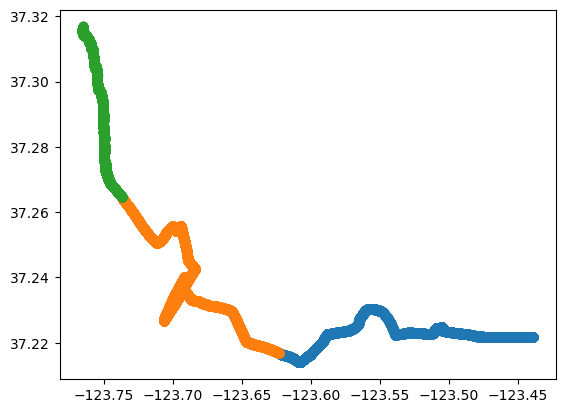

In [53]:
plt.scatter(sd_all_p.sel(time=slice(t4s_p,t4e_p)).longitude,sd_all_p.sel(time=slice(t4s_p,t4e_p)).latitude)
plt.scatter(sd_all_p.sel(time=slice(t3s_p,t3e_p)).longitude,sd_all_p.sel(time=slice(t3s_p,t3e_p)).latitude)
plt.scatter(sd_all_p.sel(time=slice(t2s_p,t2e_p)).longitude,sd_all_p.sel(time=slice(t2s_p,t2e_p)).latitude)


In [56]:
t1s, t1e = '2022-10-19-18:00','2022-10-20-01:15'   #'2022-10-18-19:00','2022-10-20-20:15'
t2s, t2e = '2022-10-20-01:15','2022-10-20-09:10'
t3s, t3e = '2022-10-20-09:10','2022-10-20-15:00'
t4s, t4e = '2022-10-20-15:00','2022-10-20-19:30'
t5s, t5e = '2022-10-20-19:30','2022-10-21-06:00'

In [57]:
all_ds = ['sd_all','sd_all_15sec','sd_all_30sec','sd_all_1min','sd_all_2min','sd_all_3min','sd_all_5min']
sampling = ['15s','30s','1min','2min','3min','5min']

In [58]:
sd_all_sub = xr.concat([sd_all.sel(time=slice(t1s,t1e)),\
                     sd_all.sel(time=slice(t2s,t2e)),\
                     sd_all.sel(time=slice(t3s,t4e)),\
                       #sd_all.sel(time=slice(t4s,t4e)),\
                       sd_all.sel(time=slice(t5s,t5e)),],dim="legs").isel(cell_depth=np.arange(0,48,2))

In [ ]:
for n,ds in enumerate(all_ds[1:]):
        exec(ds+'_sub= sd_all_sub.reset_coords(["longitude", "latitude"]).resample(time="'+sampling[n]+'").mean(dim="time")',globals())
 

In [ ]:
for n,ds in enumerate(all_ds[1:]):
        exec(ds+'_p_sub= sd_all_p_sub.reset_coords(["longitude", "latitude"]).resample(time="'+sampling[n]+'").mean(dim="time")',globals())
 

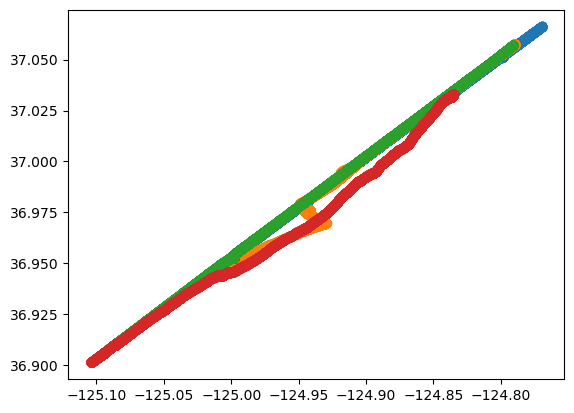

In [61]:
plt.scatter(sd_all_sub.isel(legs=0).longitude,sd_all_sub.isel(legs=0).latitude)
plt.scatter(sd_all_sub.isel(legs=1).longitude,sd_all_sub.isel(legs=1).latitude)
plt.scatter(sd_all_sub.isel(legs=2).longitude,sd_all_sub.isel(legs=2).latitude)
plt.scatter(sd_all_sub.isel(legs=3).longitude,sd_all_sub.isel(legs=3).latitude)
# plt.scatter(sd_all_sub.isel(legs=4).longitude,sd_all_sub.isel(legs=4).latitude)

In [63]:
t1,t2 = '2022-10-19-18:00','2022-10-20-23:15' 

In [64]:
def despike(u_velocity, v_velocity):
    mask_u = (u_velocity <= -1.5) | (u_velocity >=1.5)
    mask_v = (v_velocity <= -1.5) | (v_velocity >=1.5)
    
    combined_mask = mask_u | mask_v  # Combine masks to despike both u and v simultaneously
    
    u_despiked = u_velocity.where(~combined_mask, other=np.nan)
    v_despiked = v_velocity.where(~combined_mask, other=np.nan)
    
    return u_despiked, v_despiked

In [65]:
def spectrum(data,max_length,dx=0.4, window=True,detrend=True):
    
    """
        This code detrends the signal, then applies a hanning window, and then calculates the
        spectrum of the signal-returing the wavenumber/frequency along with the spectrum.
    """
    # make a shawllow copy of f
    f = data.copy()
    
    # detrend signal f
    if detrend:
        f = signal.detrend(f)   # Detrend the signal if there is a intrinsic trend present
    
    # constants
    N = max_length
    nodd = N%2
    #dx = dx     # km
    dk = 1./((N-1)*dx)
    
    # apply window
    if window:
        N2 = len(f)
        win =  np.hanning(N2)         #scipy.signal.hann(N)     #np.hanning(N)
        win =  np.sqrt(N2/(win**2).sum())*win    # preserve the variance 
        f *= win                                # windowing of the signal 
        
    #fh = np.fft.rfft(f_pad)                          # get the real part of the FFT
    fh = np.fft.rfft(f,n=N)
    spec = 2*np.real(fh.conj()*fh)/dk/(N**2)     # the spectrum is the square of the FFT (fft times it's conjigate). 
                                                 #Because we are only taking half of the record (only taking the real part) we-
                                                    #-threw half of the energy, so to get it back we multiply by 2.
    spec[0] = spec[0]/2.                         #we don't need to multiply by 2 at the centre

    if nodd:                                #if n is even then take 1/2 of the length 
        k = dk*np.arange((N-1)//2 + 1)
    else:                                   # if n is odd then take n//2 +1               
        k = dk*np.arange(N//2 + 1)
        spec[-1] = spec[-1]/2.
    
    return k, spec

In [48]:
arr_size = sd_all_5min_sub.isel(trajectory=0,legs=0,cell_depth=0).u.size
no_of_total_nans = sd_all_5min_sub.isel(trajectory=0,legs=0,cell_depth=0).u.isnull().sum().item()
no_of_nans_after_interpol = sd_all_5min_sub.isel(trajectory=0,legs=0,cell_depth=0).u.interpolate_na(dim="time", method="linear").isnull().sum().item()
no_of_nans_filled = no_of_total_nans - no_of_nans_after_interpol

percentage_of_nans_filled = (no_of_nans_filled/arr_size)*100
percentage_of_nans_filled

0.0

In [73]:
def compute_percent_interpolated(ds):
    arr_size = ds.size
    no_of_total_nans = ds.isnull().sum().item()
    no_of_nans_after_interpol = ds.interpolate_na(dim="time", method="linear").isnull().sum().item()
    no_of_nans_filled = no_of_total_nans - no_of_nans_after_interpol

    percentage_of_nans_filled = (no_of_nans_filled/arr_size)*100
    return percentage_of_nans_filled

In [74]:
(sd_all_5min_sub.isel(trajectory=0,legs=0).u.isel(cell_depth=0).isnull().sum().item()/sd_all_5min_sub.isel(trajectory=0,legs=0).u.isel(cell_depth=0).size)*100

79.67667436489607

In [79]:
def avg_spectral_dens(ds,d):
    count = 0
    empty_arr = int(np.max(ds.longitude.count(dim='time')))
    #surf_depth_index = ds.u.isel(cell_depth=0)
    l = np.where(ds.u.isel(cell_depth=0).count(dim='time')>0)[0]
    total_nans_filled = 0
    total_data_points = 0

    for leg in l: #len(ds.legs.values)# Selecting legs that have more than more than 0 data points
        for dc in range(len(ds.isel(legs=leg).u.cell_depth.values)):
            ui1 = ds.isel(legs=leg).u.isel(cell_depth=dc).interpolate_na(dim="time", method="linear")
            vi1 = ds.isel(legs=leg).v.isel(cell_depth=dc).interpolate_na(dim="time", method="linear")
            nans_filled = compute_percent_interpolated(ds.isel(legs=leg).u.isel(cell_depth=dc))
            total_nans_filled += nans_filled
            total_data_points += arr_size
            #print(percent_filled)
            u_despiked, v_despiked = despike(ui1, vi1)   # despike to remove velocity magnitude more than 1.5m/s
            
            u_nonan = u_despiked[pd.notnull(u_despiked)]
            v_nonan = v_despiked[pd.notnull(v_despiked)]

            k1, Eu1 = spectrum(u_nonan, empty_arr, dx=d) # calculating k and E with dx = mean separation distance for the leg
            k1, Ev1 = spectrum(v_nonan, empty_arr, dx=d)
            if dc == 0:
                E1 = 0.5*(Eu1+Ev1)
                k_surf = k1
            else:
                E2 = 0.5*(Eu1+Ev1)
                E1 = np.vstack([E1,E2])
        E = np.nanmean(E1,axis=0)
       # print(k_surf)
       # plt.loglog(k_surf,E)
        if leg ==0:

            kall = k_surf
            Eall= E
        else:
            Eall = np.vstack([Eall,E])
            kall =  np.vstack([kall,k_surf]) 
        
    meanE = np.nanmean(Eall,axis=0)
    meank = np.nanmean(kall,axis=0)
    spec = xr.Dataset({
    'E' : xr.DataArray(
                   data=meanE,
                   coords={'k':meank},
                   )})

    #spec= spec.sortby(spec.k)
    
    # Compute overall percentage of missing data filled
    overall_percentage_filled = (total_nans_filled / total_data_points) * 100
    print(f"\nOverall Percentage of Data Filled Due to Interpolation: {overall_percentage_filled:.2f}%")

    return spec


In [80]:
# 1Hz separation
spec_0 = avg_spectral_dens(sd_all_sub.isel(trajectory=0),1)


spec_15s_0 = avg_spectral_dens(sd_all_15sec_sub.isel(trajectory=0),15)

spec_30s_0 = avg_spectral_dens(sd_all_30sec_sub.isel(trajectory=0),30)

spec_1min_0 = avg_spectral_dens(sd_all_1min_sub.isel(trajectory=0),60)

spec_2min_0 = avg_spectral_dens(sd_all_2min_sub.isel(trajectory=0),120)

spec_3min_0 = avg_spectral_dens(sd_all_3min_sub.isel(trajectory=0),180)

spec_5min_0 = avg_spectral_dens(sd_all_5min_sub.isel(trajectory=0),300)
#El_72,Eu_72 = spec_error(Eavg_sd72_5min,24,ci=.95)


Overall Percentage of Data Filled Due to Interpolation: 0.04%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%


In [81]:
spec_0_p = avg_spectral_dens(sd_all_p_sub,1)
# spec_1_p = avg_spectral_dens(sd_all_p_sub.isel(trajectory=1),1)

spec_15s_0_p = avg_spectral_dens(sd_all_15sec_p_sub,15)
# spec_15s_1_p = avg_spectral_dens(sd_all_15sec_p_sub.isel(trajectory=1),15)

spec_30s_0_p = avg_spectral_dens(sd_all_30sec_p_sub,30)
# spec_30s_1_p = avg_spectral_dens(sd_all_30sec_p_sub.isel(trajectory=1),30)

spec_1min_0_p = avg_spectral_dens(sd_all_1min_p_sub,60)
# spec_1min_1_p = avg_spectral_dens(sd_all_1min_p_sub.isel(trajectory=1),60)


spec_2min_0_p = avg_spectral_dens(sd_all_2min_p_sub,120)
# spec_2min_1_p = avg_spectral_dens(sd_all_2min_p_sub.isel(trajectory=1),120)


spec_3min_0_p = avg_spectral_dens(sd_all_3min_p_sub,180)
# spec_3min_1_p = avg_spectral_dens(sd_all_3min_p_sub.isel(trajectory=1),180)

spec_5min_0_p = avg_spectral_dens(sd_all_5min_p_sub,300)
# spec_5min_1_p = avg_spectral_dens(sd_all_5min_p_sub.isel(trajectory=1),300)


Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%

Overall Percentage of Data Filled Due to Interpolation: 0.00%


In [136]:
data = np.load("../Data/wavenumber_3-min_data.npz")
pilot_k_wavespec = data["pilot_k"]
pilot_E_wavespec = data["pilot_E"]
iop_k_wavespec = data["iop_k"]
iop_E_wavespec = data["iop_E"]

In [176]:
E_mid = np.median(iop_E_wavespec)  # Choose median spectral value
np.abs(iop_E_wavespec - E_mid).argmin()

30

In [175]:
l_error_wave_iop,u_error_wave_iop  = spec_error(iop_E_wavespec,12,ci=.95)
l_error_wave_pilot,u_error_wave_pilot  = spec_error(pilot_E_wavespec,21,ci=.95)

In [86]:
l_error_freq_iop,u_error_freq_iop  = spec_error(spec_5min_0.E,12,ci=.95)
l_error_freq_pilot,u_error_freq_pilot  = spec_error(spec_5min_0_p.E,21,ci=.95)

/var/folders/x0/gfncmvlj2pb93b9982y5_4pm0000gn/T/ipykernel_26660/4021293960.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[0].errorbar(1e-5, spec_5min_0.E[36],
/var/folders/x0/gfncmvlj2pb93b9982y5_4pm0000gn/T/ipykernel_26660/4021293960.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax[1].errorbar(0.9e-1, iop_E_wavespec[30],
/var/folders/x0/gfncmvlj2pb93b9982y5_4pm0000gn/T/ipykernel_26660/4021293960.py:61: RuntimeWarning: divide by zero encountered in divide
  return 1 / x


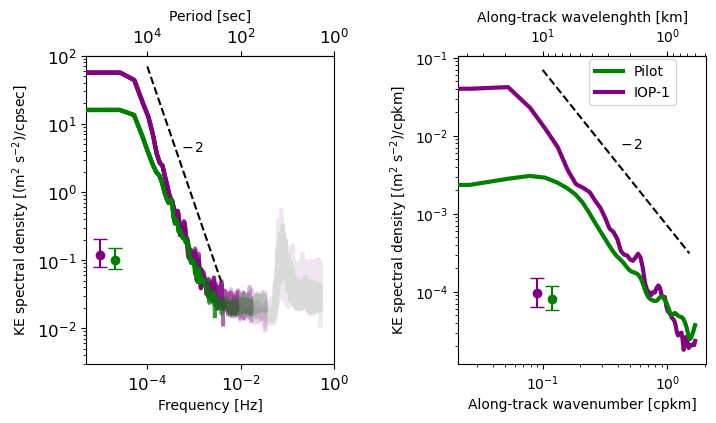

In [181]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
clrs = ['purple','m','navy','maroon','g','saddlebrown','coral',]
#clrs = ['coral','g','m','navy','maroon','purple','saddlebrown']


ax[0].loglog(spec_5min_0_p.k,spec_5min_0_p.E,color=clrs[4],linewidth=3,alpha=1,zorder=13)
ax[0].loglog(spec_5min_0.k,spec_5min_0.E,color=clrs[0],linewidth=3,alpha=1,zorder=12)

# plt.fill_between(spec_5min_0_p.k,l_error_freq_pilot,u_error_freq_pilot, color=clrs[4], alpha=0.5)
# plt.fill_between(spec_5min_0.k,l_error_freq_iop,u_error_freq_iop, color=clrs[0], alpha=0.5)

ax[0].errorbar(1e-5, spec_5min_0.E[36], 
             yerr=[[spec_5min_0.E[36] - l_error_freq_iop[36]], [u_error_freq_iop[36] - spec_5min_0.E[36]]], 
             fmt='ko', color = clrs[0],capsize=5, label="95% Confidence Interval")


ax[0].errorbar(2e-5, spec_5min_0_p.E[32], 
             yerr=[[spec_5min_0_p.E[32] - l_error_freq_pilot[32]], [u_error_freq_pilot[32] - spec_5min_0_p.E[32]]], 
             fmt='o', color = clrs[4], capsize=5, label="95% Confidence Interval")



ax[0].loglog(spec_0_p.k,spec_0_p.E,color=clrs[4],linewidth=3,alpha=0.1,zorder=1)
ax[0].loglog(spec_0.k,spec_0.E,color=clrs[0],linewidth=3,alpha=0.1,zorder=0)

ax[0].loglog(spec_15s_0_p.k,spec_15s_0_p.E,color=clrs[4],linewidth=3,alpha=0.2,zorder=3)
ax[0].loglog(spec_15s_0.k,spec_15s_0.E,color=clrs[0],linewidth=3,alpha=0.2,zorder=2)

ax[0].loglog(spec_30s_0_p.k,spec_30s_0_p.E,color=clrs[4],linewidth=3,alpha=0.3,zorder=5)
ax[0].loglog(spec_30s_0.k,spec_30s_0.E,color=clrs[0],linewidth=3,alpha=0.3,zorder=4)

ax[0].loglog(spec_1min_0_p.k,spec_1min_0_p.E,color=clrs[4],linewidth=3,alpha=0.4,zorder=7)
ax[0].loglog(spec_1min_0.k,spec_1min_0.E,color=clrs[0],linewidth=3,alpha=0.4,zorder=6)

ax[0].loglog(spec_2min_0_p.k,spec_2min_0_p.E,color=clrs[4],linewidth=3,alpha=0.6,zorder=9)
ax[0].loglog(spec_2min_0.k,spec_2min_0.E,color=clrs[0],linewidth=3,alpha=0.6,zorder=8)

ax[0].loglog(spec_3min_0_p.k,spec_3min_0_p.E,color=clrs[4],linewidth=3,alpha=0.8,zorder=11)
ax[0].loglog(spec_3min_0.k,spec_3min_0.E,color=clrs[0],linewidth=3,alpha=0.8,zorder=10)


#ax[0].legend(('Pilot','IOP-1'),bbox_to_anchor=(1.012,1.012),fontsize=14)
kc = np.array([1e-4,4e-3])
ax[0].loglog(kc,7e-7*kc**-2,'k--')
#plt.loglog(kc1,0.00035*kc1**-3,'k--')
plt.text(0.38,0.69,'$-\,2$',transform=ax[0].transAxes)
#plt.text(0.89,0.46,'$-\,3$',transform=ax.transAxes)
#plt.text(0.5,0.55,'3.5 km',transform=ax.transAxes)
ax[0].set_xlabel('Frequency [Hz]',fontsize=10)
ax[0].tick_params(axis='x', labelsize='large')
ax[0].tick_params(axis='y', labelsize='large')
ax[0].set_ylabel('KE spectral density [(m$^2$ s$^{-2}$)/cpsec]',fontsize=10)
p = [28e-2,28e-2]
#plt.loglog(l,[1e-3,10],'k--')
#plt.loglog(p,[2e-3,0.9e-3],'k--')
def forward(x):
    return 1 / x


def inverse(x):
    return 1 / x

secax = ax[0].secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Period [sec]',fontsize=10)
secax.tick_params(axis='x', labelsize='large')  
ax[0].set_ylim(3e-3,1e2)
ax[0].set_xlim(5e-6,1)


ax[1].loglog(pilot_k_wavespec,pilot_E_wavespec,color=clrs[4],linewidth=3,alpha=1,zorder=7)
ax[1].loglog(iop_k_wavespec,iop_E_wavespec,color=clrs[0],linewidth=3,alpha=1,zorder=6)

ax[1].errorbar(0.9e-1, iop_E_wavespec[30], 
             yerr=[[iop_E_wavespec[30] - l_error_wave_iop[30]], [u_error_wave_iop[36] - iop_E_wavespec[30]]], 
             fmt='ko', color = clrs[0],capsize=5, label="95% Confidence Interval")


ax[1].errorbar(1.2e-1, pilot_E_wavespec[28], 
             yerr=[[pilot_E_wavespec[28] - l_error_wave_pilot[28]], [u_error_wave_pilot[32] - pilot_E_wavespec[28]]], 
             fmt='o', color = clrs[4], capsize=5, label="95% Confidence Interval")



ax[1].legend(('Pilot','IOP-1'),bbox_to_anchor=(0.5,1.012),fontsize=10)
kc = np.array([0.1,1.5])
kc1 = np.array([0.5,1.])
ax[1].loglog(kc,0.0007*kc**-2,'k--')
plt.text(0.65,0.7,'$-\,2$',transform=ax[1].transAxes)
ax[1].set_xlabel('Along-track wavenumber [cpkm]',fontsize=10)
ax[1].set_ylabel('KE spectral density [(m$^2$ s$^{-2}$)/cpkm]',fontsize=10)
p = [28e-2,28e-2]

secax = ax[1].secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('Along-track wavelenghth [km]',fontsize=10)

plt.subplots_adjust(wspace=0.5)
#ax.set_aspect(0.4)
plt.savefig('../Plots/mean_spectra_comp_IOP_sds_1072_bboxInside_final_data_padded_4leg_iop_freq_wavenumber.png',bbox_inches='tight',dpi=150)

In [98]:
def plot_spectrum(sd_all_sub, despike_func, max_len=None):
    num_legs = sd_all_sub.dims['legs']
    num_depths = sd_all_sub.dims['cell_depth']
    if max_len is None:
        max_len = int(np.max(sd_all_sub.isel(trajectory=0).longitude.count(dim='time')))
        
    print(num_legs,num_depths)
    fig, axes = plt.subplots(num_depths,num_legs, figsize=(num_legs * 3,45)) 
    for i in range(num_legs):
        for j in range(num_depths):
            u, v = sd_all_sub.isel(trajectory=0, legs=i, cell_depth=j).u, sd_all_sub.isel(trajectory=0, legs=i, cell_depth=j).v
            u_despiked, v_despiked = despike_func(u, v)
            
            u_nonan = u_despiked[pd.notnull(u_despiked)]
            v_nonan = v_despiked[pd.notnull(v_despiked)]
            N2 = len(u_nonan)
            
            if N2 == 0:  # Skip if there's no data after despiking
                continue
            
            win = np.hanning(N2)
            win = np.sqrt(N2 / (win**2).sum()) * win
            u_nonan_tap = u_nonan * win
            v_nonan_tap = v_nonan * win
            
            N = max_len
            nodd = N % 2
            dx = 1
            dk = 1. / ((N-1) * dx)
            
            fh_n = np.fft.rfft(u_nonan_tap, n=N)
            fh_v_n = np.fft.rfft(v_nonan_tap, n=N)
            spec_u_n = 2 * np.real(fh_n.conj() * fh_n) / dk / (N**2)
            spec_v_n = 2 * np.real(fh_v_n.conj() * fh_v_n) / dk / (N**2)
            
            if nodd:
                k = dk * np.arange((N-1) // 2 + 1)
            else:
                k = dk * np.arange(N // 2 + 1)
                spec_u_n[-1] = spec_u_n[-1] / 2.
                spec_v_n[-1] = spec_v_n[-1] / 2.
            
            ax = axes[j, i] if num_legs > 1 and num_depths > 1 else axes[max(j, i)]
            ax.loglog(k, 0.5 * (spec_u_n + spec_v_n), alpha=0.2)
            ax.set_title(f'Leg {i}, Depth {j}')
            ax.grid(True)
            
    plt.tight_layout()
    plt.show()



5 24


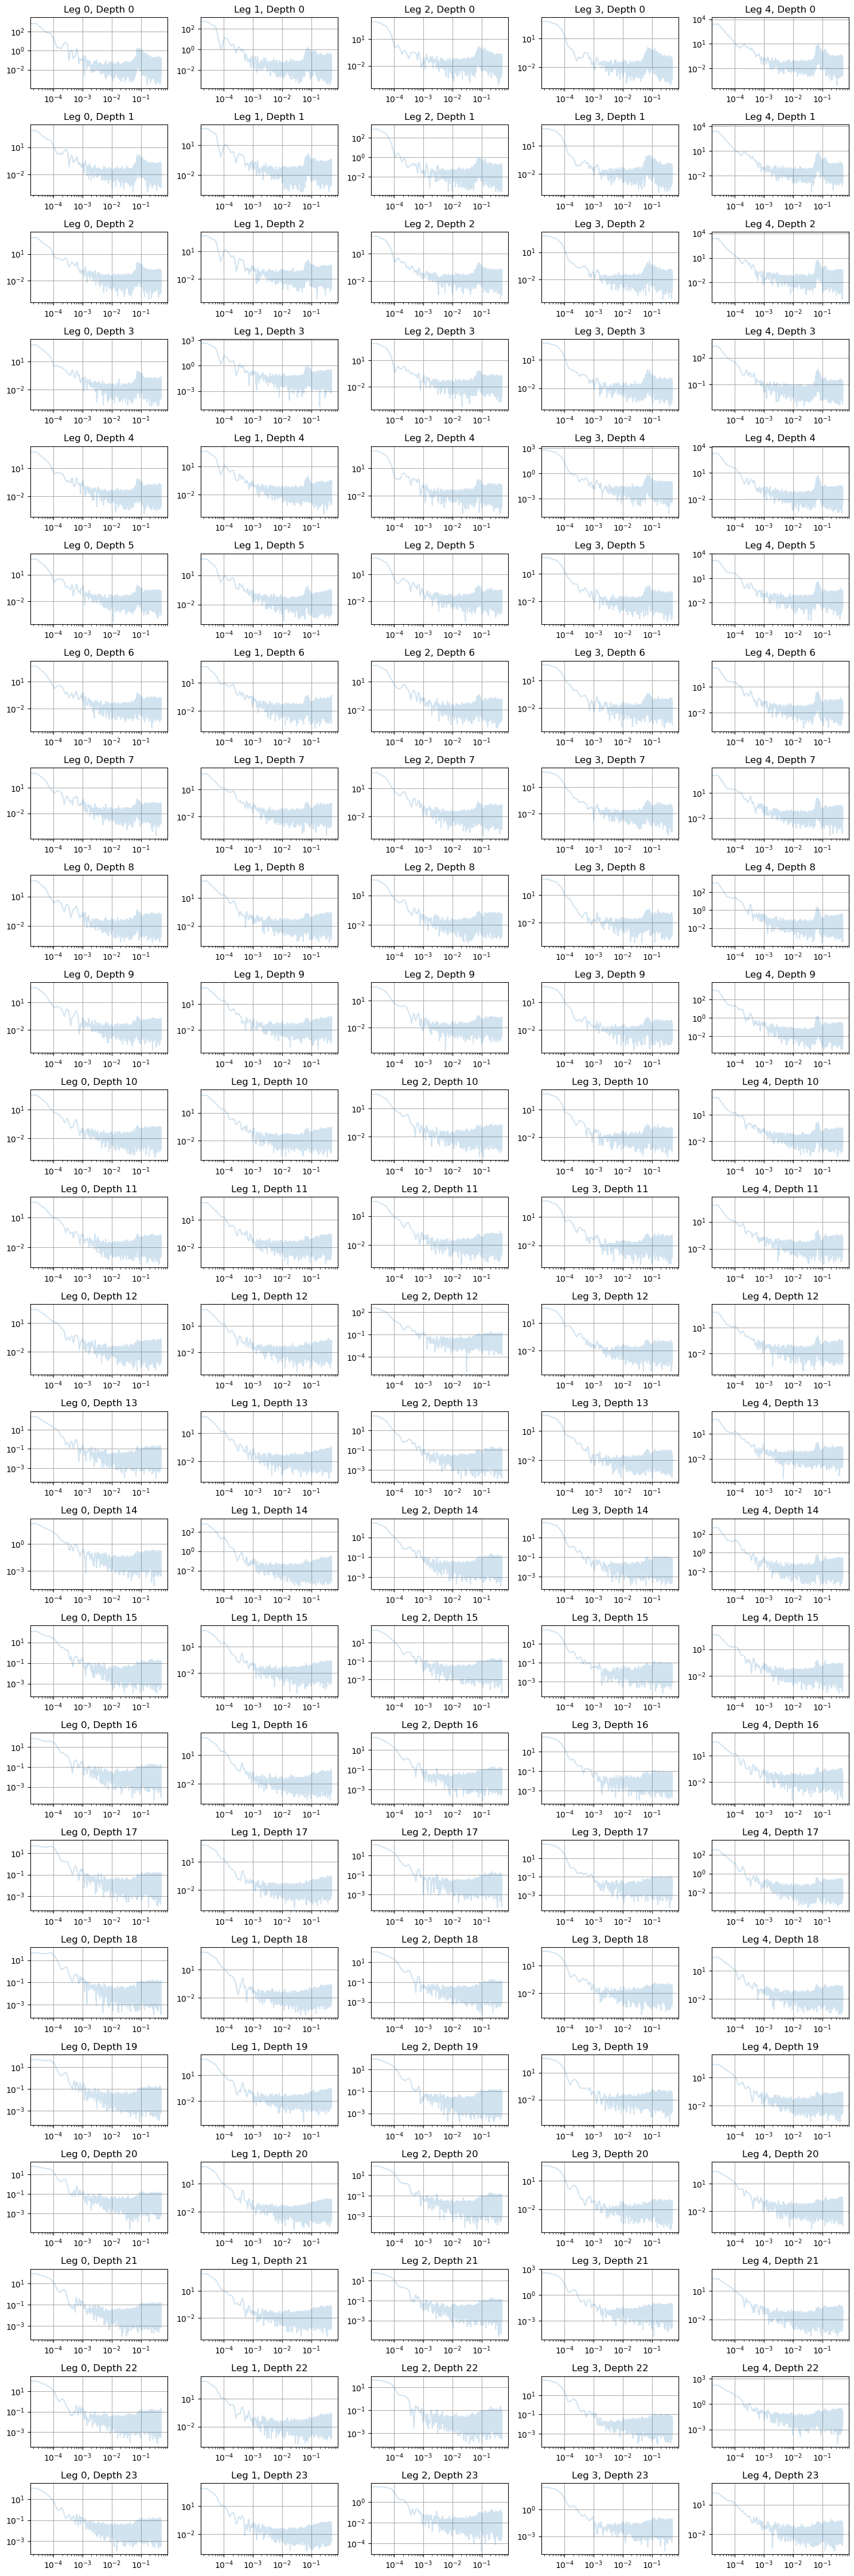

In [99]:
plot_spectrum(sd_all_sub, despike)